In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def real_solve(x, y):
    return np.log(x + y + 1)

def f(x, t):
    return 0
def u0(x):
    return np.log(x+1)
def u0_2(x):
    return -1/(x+1)**2
def u1(x):
    return 1/(x+1)
def nu1(t):
    return np.log(t+1) - 1/(t+1)
def nu2(t):
    return np.log(t+2)
sigma0 = 1
a, b = 0, 1
c, d = 0, 0.5

In [3]:
def plot(x, t, y):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    X, T = np.meshgrid(x, t)
    Y = real_solve(X, T)
    ax.plot_surface(X, T, Y, alpha=0.6)
    ax.plot_surface(X, T, y, alpha=0.6)

In [4]:
def max_val(x, t, y):
    residual = []
    for j in range(len(t)):
        for i in range(len(x)):
            residual.append(y[j][i] - real_solve(x[i],t[j]))
    return np.max(np.abs(residual))

In [5]:
def TDMA(a, c, b, f):
    n = len(f)
    alpha = [0] * (n+1)
    beta  = [0] * (n+1)
    y = [0.] * (n)
    
    alpha[1] = -b[0] / c[0]
    beta[1] =   f[0] / c[0]
    for i in range(1, n - 1):
        d = (c[i] - (-a[i-1] * alpha[i]))
        alpha[i + 1] = -b[i] / d
        beta[i+1] = (f[i] + (-a[i-1] * beta[i])) / d
    
    beta[n] = ((f[n-1] + (-a[n-2] * beta[n-1])) / 
               (c[n-1] - (-a[n-2] * alpha[n-1])))
              
    
    y[n-1] = beta[n]
    for i in range(n-2, -1, -1):
        y[i] = y[i+1] * alpha[i+1] + beta[i+1]
    return y

In [6]:
def solve_expicit(h, tau):
    N1 = int((b-a)/h)
    N2 = int((d-c)/tau + 0.5)
    x = np.array([i * h for i in range(N1+1)])
    t = np.array([tau * i for i in range(N2+1)])
    y = np.zeros((N2+1,N1+1))
    y[0] = u0(x)
    y[1] = y[0] + tau * u1(x) + tau**2 * (u0_2(x) + f(x, 0)) / 2
    for j in range(1, N2):
        for i in range(1, N1):
            y[j+1][i] = 2*y[j][i] - y[j-1][i] + tau**2*((y[j][i+1]-2*y[j][i] + y[j][i-1])/h**2 + f(x[i],t[j]))
        
        y[j+1][0] = (y[j+1][1]/h + nu1(t[j+1]) + h*((2*y[j][0] - y[j-1][0])/tau**2 + f(0, t[j+1]))/2)/(sigma0 + 1/h + h/(2*tau**2))
        y[j+1][N1] = nu2(t[j+1])
    
    print('max: {}'.format(round(max_val(x, t, y), 5)))
    plot(x, t, y)

In [7]:
def form_matrix(j, t, x, h, tau, nu, n, y, y1):
    a = [0 if i == n-2 else -nu/h**2 for i in range(n-1)]
    c = [-1/h if i == 0 else -nu/h**2 for i in range(n-1)]
    b = [1 + 1/h + h/(2*tau**2) if i == 0 else (1/tau**2 + 2*nu/h**2) for i in range(n-1)]
    b.append(1)
    s = [0] * n
    s[0] = nu1(t[j+1]) - h*((-2*y[0] + y1[0])/tau**2 - f(0, t[j+1]))/2
    s[n-1] = nu2(t[j+1])
    for i in range(1, n-1):
        s[i] = (2*y[i]-y1[i])/tau**2  + nu*(y1[i+1]-2*y1[i]+y1[i-1])/h**2 #+ (1-2*nu)*(y[i+1]-2*y[i]+y[i-1])/h**2
    return a, b, c, s

In [8]:
def solve_non_expicit(h, tau, s):
    N1 = int((b-a)/h)
    N2 = int((d-c)/tau + 0.5)
    x = np.array([i * h for i in range(N1+1)])
    t = np.array([tau * i for i in range(N2+1)])
    y = np.zeros((N2+1,N1+1))
    y[0] = u0(x)
    y[1] = y[0] + tau * u1(x) + tau**2 * (u0_2(x) + f(x, 0)) / 2
    for j in range(1, N2):
        q, w, e, r = form_matrix(j, t, x, h, tau, s, N1+1, y[j], y[j-1]) 
        y[j+1] = TDMA(q, w, e, r)
    print('max: {}'.format(round(max_val(x, t, y), N2+1)))
    plot(x, t, y)

max: 0.000955


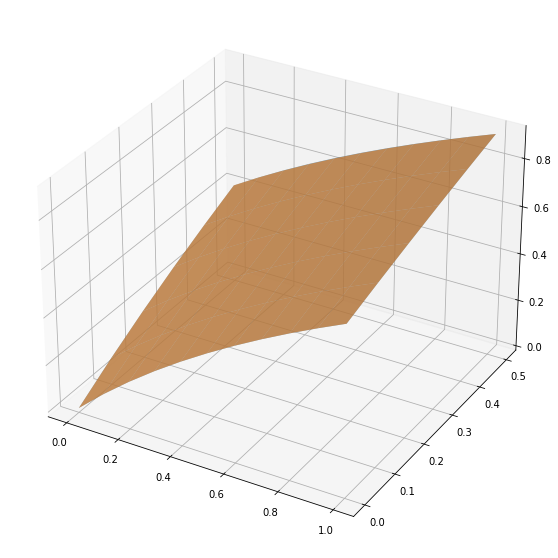

In [9]:
solve_non_expicit(0.1, 0.1, 1/2)

max: 0.00111


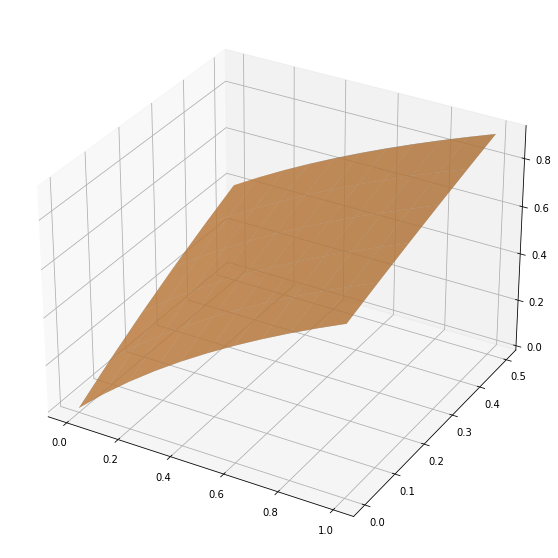

In [10]:
solve_expicit(0.1, 0.1)